# Broken electrodes
In some setups, not all electrodes are used all the time. This can be because some of them are being used as stimulation electrodes and in some cases these electrodes are broken or too noisy to be included. In some other cases, the electrodes can be irregularly placed. In this tutorial we shall see how to handle such cases.
1. Remove broken electrodes, those which are used in stimulation
2. Error in the estimation for a given source, with broken electrodes
3. Average error across many sources, with broken electrodes

In [1]:
%matplotlib inline
import numpy as np
from scipy.integrate import simps
from kcsd import csd_profile as CSD
from kcsd import KCSD2D

# Step 1 - define a region of interest
csd_at = np.mgrid[0.:1.:100j,                                                                                                                                                           
                  0.:1.:100j]
csd_x, csd_y = csd_at

# Step 2 - test current sources as True CSD
def current_source(csd_type, csd_seed):
    return csd_type(csd_at, seed=csd_seed)

### Setting up the defaults
Like in the basic tutorial, we create a space in which we would like to test the KCSD method, and we change the true current source generation into a function for the sake of convenience, so that we evaluation the error averages for multiple csd source.

In [2]:
# Step 3 - location of electrodes
ele_x, ele_y = np.mgrid[0.05: 0.95: 10j,
                        0.05: 0.95: 10j]
ele_pos = np.vstack((ele_x.flatten(), ele_y.flatten())).T

def remove_electrodes(ele_pos, num_broken, broken_seed=42):                                                                                                                                 
    rstate = np.random.RandomState(broken_seed)  # just a random seed                                                                                                                                        
    rmv = rstate.choice(ele_pos.shape[0], num_broken, replace=False)                                                                                                                                
    ele_pos = np.delete(ele_pos, rmv, 0)
    return ele_pos

ele_pos = remove_electrodes(ele_pos, 5)  # we discard 5 electrodes from 100

### 1. Remove broken electrodes
In order to simulate the effect of broken electrodes or discard the ones used in stimulation protocols, we can write a function `remove_electrodes` that takes all the default electrode positions and a number of electrodes that need to be removed. In this case, we remove the electrodes in random. Like we did previously, to enable repeatability we pass a `broken_seed` variable, such that at each subsequent runs it is the same set of electrodes that are discarded. By changing this seed, a different set of electrodes can be discarded.

In [3]:
# Step 4 - Computing the potentials at these electrode positions
def integrate_2d(csd_at, true_csd, ele_pos, h, csd_lims):
    csd_x, csd_y = csd_at
    xlin = csd_lims[0]                                                                                                                                                                                      
    ylin = csd_lims[1]                                                                                                                                                                                      
    Ny = ylin.shape[0]                                                                                                                                                                                      
    m = np.sqrt((ele_pos[0] - csd_x)**2 + (ele_pos[1] - csd_y)**2)                                                                                                           
    m[m < 0.0000001] = 0.0000001
    y = np.arcsinh(2 * h / m) * true_csd
    integral_1D = np.zeros(Ny)                                        
    for i in range(Ny):                                                  
        integral_1D[i] = simps(y[:, i], ylin)
    integral = simps(integral_1D, xlin)
    return integral

def forward_model(ele_pos, csd_at, true_csd):
    pots = np.zeros(ele_pos.shape[0])
    xlin = csd_at[0, :, 0]
    ylin = csd_at[1, 0, :]
    h = 50.  # distance between the electrode plane and the CSD plane
    sigma = 1.0 # S/m
    for ii in range(ele_pos.shape[0]):                                                                                                                                                                      
        pots[ii] = integrate_2d(csd_at, true_csd,                                                                                                                                                         
                                [ele_pos[ii][0], ele_pos[ii][1]], h,                                                                                                                                      
                                [xlin, ylin])
    pots /= 2 * np.pi * sigma
    pots = pots.reshape((len(ele_pos), 1)) # first time point
    return pots

# Step 5,6 KCSD computation with cross validation
def do_kcsd(ele_pos, pots_new):
    h = 50.  # distance between the electrode plane and the CSD plane
    sigma = 1.0 # S/m
    k = KCSD2D(ele_pos, pots_new, h=h, sigma=sigma,                                                                                                                                                       
               xmin=0.0, xmax=1.0,
               ymin=0.0, ymax=1.0,
               n_src_init=1000, src_type='gauss', R_init=1.)
    k.cross_validate(Rs=np.linspace(0.01, 0.15, 15))
    return k

# Step 7 Error measures
def point_errors(true_csd, est_csd):
    nrm_est = est_csd.reshape(est_csd.size, 1) / np.max(np.abs(est_csd))
    nrm_csd = true_csd.reshape(true_csd.size, 1) / np.max(np.abs(true_csd))
    err = np.linalg.norm(nrm_csd - nrm_est, axis=1).reshape(true_csd.shape)
    return err

The remaining steps are continuation from the basic tutorial, where we first compute the forward model to obtain the potentials at the electrode positions, we write a new function called `forward_model` and then use the electrode positions, and the potentials at these positions to estimate the current source density using cross validation in the `do_kcsd` function. We also add the fuction that we used to comptue the `point_error` measures from the noisy_electrodes tutorial to compare the estimation quality.

In [8]:
def calculate_error(csd_seed, ele_pos, broken_ele=5):
    true_csd = current_source(csd_type=CSD.gauss_2d_small, csd_seed=csd_seed)
    ele_pos = remove_electrodes(ele_pos, broken_ele)
    pots = forward_model(ele_pos, csd_at, true_csd)
    k = do_kcsd(ele_pos, pots)
    err = point_errors(true_csd, k.values('CSD'))
    return ele_pos, k, err

ele_pos_new, k, err = calculate_error(csd_seed=15, ele_pos=ele_pos, broken_ele=5)

No lambda given, using defaults
Cross validating R (all lambda) : 0.01
Cross validating R (all lambda) : 0.02
Cross validating R (all lambda) : 0.03
Cross validating R (all lambda) : 0.04
Cross validating R (all lambda) : 0.05
Cross validating R (all lambda) : 0.06
Cross validating R (all lambda) : 0.07
Cross validating R (all lambda) : 0.08
Cross validating R (all lambda) : 0.09
Cross validating R (all lambda) : 0.1
Cross validating R (all lambda) : 0.11
Cross validating R (all lambda) : 0.12
Cross validating R (all lambda) : 0.13
Cross validating R (all lambda) : 0.14
Cross validating R (all lambda) : 0.15
R, lambda : 0.15 3.16227766017e-14


### 2. Error in estimation, with broken electrodes
We write all the steps into a fuction `calculate_error` which takes a `csd_seed` as an input value, all electrode positions `ele_pos` as the electrode locations in the setup, and `broken_num` as the number of electrodes broken in this setup. It computes the True csd, selects the electrodes to be used, computes the potentials generated at these valid electrode locations, computes the kcsd, and also computes the error in the estimation from the true csd.
***
Below, we use the function to display a heatmap in grey scale of the error in the kcsd estimation from the true sources. We also display the electrodes and are being considered in the kcsd method. 

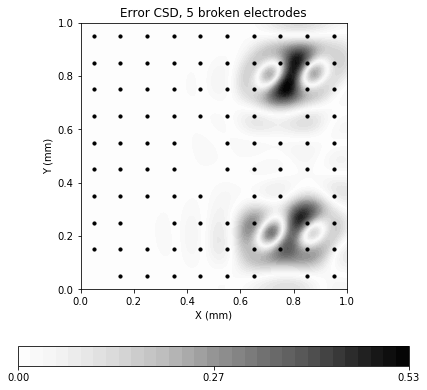

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def make_error_plot(xx, yy, error, ele_pos, title='Error CSD'):
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    t_max = np.max(np.abs(error))
    levels = np.linspace(0, t_max, 32)
    im = ax.contourf(xx, yy, error, levels=levels, cmap=cm.Greys)
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title(title)
    ticks = np.linspace(0, t_max, 3, endpoint=True)
    plt.colorbar(im, orientation='horizontal', format='%.2f', ticks=ticks)
    ax.scatter(ele_pos[:, 0], ele_pos[:, 1], 10, c='k')
    return ax
    
make_error_plot(k.estm_x, k.estm_y, err, ele_pos_new, title='Error CSD, 5 broken electrodes')

In [17]:
seed_list = range(15, 17)
error_list = []
for csd_seed in seed_list:
    ele_pos_new, k, err = calculate_error(csd_seed=csd_seed, ele_pos=ele_pos, broken_ele=5)
    error_list.append(err)
avg_error = sum(error_list) / len(error_list)

No lambda given, using defaults
Cross validating R (all lambda) : 0.01
Cross validating R (all lambda) : 0.02
Cross validating R (all lambda) : 0.03
Cross validating R (all lambda) : 0.04
Cross validating R (all lambda) : 0.05
Cross validating R (all lambda) : 0.06
Cross validating R (all lambda) : 0.07
Cross validating R (all lambda) : 0.08
Cross validating R (all lambda) : 0.09
Cross validating R (all lambda) : 0.1
Cross validating R (all lambda) : 0.11
Cross validating R (all lambda) : 0.12
Cross validating R (all lambda) : 0.13
Cross validating R (all lambda) : 0.14
Cross validating R (all lambda) : 0.15
R, lambda : 0.15 3.83118684956e-16
No lambda given, using defaults
Cross validating R (all lambda) : 0.01
Cross validating R (all lambda) : 0.02
Cross validating R (all lambda) : 0.03
Cross validating R (all lambda) : 0.04
Cross validating R (all lambda) : 0.05
Cross validating R (all lambda) : 0.06
Cross validating R (all lambda) : 0.07
Cross validating R (all lambda) : 0.08
Cross

### 3. Average error for multiple sources
As we observe that the error in the estimation is closely tied to the current source that is being used to test. We can compute the average error across multiple source seeds, and this would give us an overall picture of the estimation capabilities of the kcsd method. For instance we show for 2 seeds here, but in principle any number of sources may be tested. The more the tested sources, the better our understanding of the setup. This step is computationally expensive, however this would have to be carried out only once for an electrode design configuration, ie., it depends on the electrode locations. 
***
We can then use the function we defined earlier to display the average error for the two seeds.

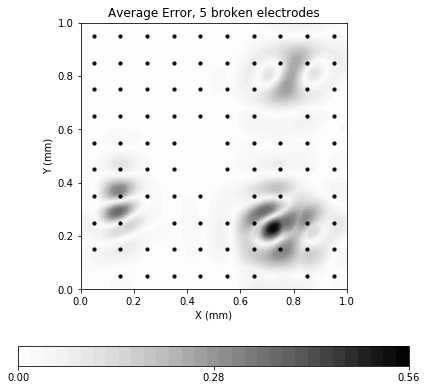

In [18]:
make_error_plot(k.estm_x, k.estm_y, avg_error, 
                ele_pos_new, title='Average Error, 5 broken electrodes')